# Final project
The Allen–Cahn equation (after John W. Cahn and Sam Allen) is a reaction–diffusion equation of mathematical physics which describes the process of phase separation in multi-component alloy systems, including order-disorder transitions.

The equation describes the time evolution of a scalar-valued state variable $\eta$  on a domain $\Omega=[0,1]$  during a time interval $[0,T]$, and is given (in one dimension) by:

$$
\frac{\partial \eta}{\partial t} - \varepsilon^2 \eta'' + f'(\eta) = 0, \qquad \eta'(0, t) = \eta'(1, t) = 0,\qquad\eta(x,0) = \eta_0(x)
$$

where $f$ is a double-well potential, $\eta_0$ is the initial condition, and $\varepsilon$ is the characteristic width of the phase transition.

This equation is the L2 gradient flow of the Ginzburg–Landau free energy functional, and it is closely related to the Cahn–Hilliard equation.

A typical example of double well potential is given by the following function

$$
f(\eta) = \eta^2(\eta-1)^2
$$

which has two minima in $0$ and $1$ (the two wells, where its value is zero), one local maximum in $0.5$, and it is always greater or equal than zero.

The two minima above behave like "attractors" for the phase $\eta$. Think of a solid-liquid phase transition (say water+ice) occupying the region $[0,1]$. When $\eta = 0$, then the material is liquid, while when $\eta = 1$ the material is solid (or viceversa).

Any other value for $\eta$ is *unstable*, and the equation will pull that region towards either $0$ or $1$.

Discretisation of this problem can be done by finite difference in time. For example, a fully explicity discretisation in time would lead to the following algorithm.

We split the interval $[0,T]$ in `n_steps` intervals, of dimension `dt = T/n_steps`. Given the solution at time `t[k] = k*dt`, it i possible to compute the next solution at time `t[k+1]` as

$$
\eta_{k+1} = \eta_{k} + \Delta t \varepsilon^2 \eta_k'' - \Delta t f'(\eta_k)
$$

Such a solution will not be stable. A possible remedy that improves the stability of the problem, is to treat the linear term $\Delta t \varepsilon^2 \eta_k''$ implicitly, and keep the term $-f'(\eta_k)$ explicit, that is:

$$
\eta_{k+1} - \Delta t \varepsilon^2 \eta_k'' = \eta_{k} - \Delta t f'(\eta_k)
$$

Grouping together the terms on the right hand side, this problem is identical to the one we solved in the python notebook number 9, with the exception of the constant $\Delta t \varepsilon^2$ in front the stiffness matrix.

In particular, given a set of basis functions $v_i$, representing $\eta = \eta^j v_j$ (sum is implied), we can solve the problem using finite elements by computing

$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} = \big((v_i, v_j) \eta^j_{k} - \Delta t (v_i, f'(\eta_k)\big)
$$
where a sum is implied over $j$ on both the left hand side and the right hand side. Let us remark that while writing this last version of the equation we moved from a forward Euler scheme to a backward Euler scheme for the second spatial derivative term: that is, we used $\eta^j_{k+1}$ instead of $\eta^j_{k}$.  

This results in a linear system

$$
A x = b
$$

where 

$$
A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) 
$$

and 

$$
b_i = M_{ij} \big(\eta_k^j - \Delta t f'(\eta_k^j)\big)
$$

where we simplified the integration on the right hand side, by computing the integral of the interpolation of $f'(\eta)$.

## Step 1

Write a finite element solver, to solve one step of the problem above, given the solution at the previous time step, using the same techniques used in notebook number 9.

In particular:

1. Write a function that takes in input a vector representing $\eta$, an returns a vector containing $f'(\eta)$. Call this function `F`.

2. Write a function that takes in input a vector of support points of dimension `ndofs` and the degree `degree` of the polynomial basis, and returns a list of basis functions (piecewise polynomial objects of type `PPoly`) of dimension `ndofs`, representing the interpolatory spline basis of degree `degree`

3. Write a function that, given a piecewise polynomial object of type `PPoly` and a number `n_gauss_quadrature_points`, computes the vector of global_quadrature_points and global_quadrature_weights, that contains replicas of a Gauss quadrature formula with `n_gauss_quadrature_points` on each of the intervals defined by `unique(PPoly.x)`

4. Write a function that, given the basis and the quadrature points and weights, returns the two matrices $M$ and $K$ 

## Step 2

Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step `dt`, a number of degrees of freedom `ndofs`, and a polynomial degree `k`.

1. Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension `(int(T/dt), ndofs)`  containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution

2. Write a function that takes all the solutions `eta`, the basis functions, a stride number `s`, and a resolution `res`, and plots on a single plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$, computed on `res` equispaced points between zero and one

## Step 3

Solve the problem for all combinations of

1. eps = [01, .001]

2. ndofs = [16, 32, 64, 128]

3. degree = [1, 2, 3]

3. dt = [.25, .125, .0625, .03125, .015625]

with $\eta_0 = \sin(2 \pi x)+1$.

Plot the final solution at $t=1$ in all cases. What do you observe? What happens when you increase ndofs and keep dt constant? 

## Step 4 (Optional)

Instead of solving the problem explicitly, solve it implicitly, by using backward euler method also for the non linear term. This requires the solution of a Nonlinear problem at every step. Use scipy and numpy methods to solve the non linear iteration.

In [1]:
%pylab inline
import sympy as sym
import scipy
from scipy.interpolate import *
from scipy.integrate import *

Populating the interactive namespace from numpy and matplotlib


In [62]:
# Step 1.1

def F(eta):
    """
    Derivative of f(eta)
    """
    return 2*eta*(eta-1)*(2*eta-1)

In [63]:
# Step 1.2

def compute_basis_functions(support_points, degree):
    basis_functions = []
    for i in range(len(support_points)):
        temp = support_points*0
        temp[i] = 1
        bi = PPoly.from_spline(splrep(support_points, temp, k=degree))
        basis_functions.append(bi)
    return basis_functions

In [64]:
# Step 1.3

def compute_global_quadrature(basis, n_gauss_quadrature_points):
    # Create a Gauss quadrature formula with n_gauss_quadrature_points, extract the intervals from basis (i.e., unique(basis.x)), and 
    # create len(x)-1 shifted and scaled Gauss quadrature formulas that can be used to integrate on each interval. Put all of these 
    # together, and return the result
    
    # return gloabl_quadrature, global_weights
    
    intervals = unique(basis[0].x)
    quad_points, weights = numpy.polynomial.legendre.leggauss(n_gauss_quadrature_points+1)  
    quad_points = (quad_points+1)/2
    weights /= 2
    #compute the first order difference points
    discr_difference = diff(intervals)
    discr_diff_length = len(discr_difference)
    
    gloabl_quadrature = array([intervals[i] + discr_difference[i] * quad_points
                               for i in range(discr_diff_length)]).reshape((-1,))
    global_weights = array([weights * discr_difference[i]
                            for i in range(discr_diff_length)]).reshape((-1,))
    return gloabl_quadrature, global_weights

In [65]:
# Step 1.4

def compute_system_matrices(basis, gloabl_quadrature, global_weights):
    n_basis_funct = len(basis)
    derivative_basis = []
    #derivative_basis =  basis.derivative(1)
    for i in range(n_basis_funct):
        derivative_basis.append(basis[i].derivative(1))
    basis_quad = array([basis[i](gloabl_quadrature)
                        for i in range(n_basis_funct)]).T
    derivative_basis_quad = array([derivative_basis[i](gloabl_quadrature)
                                   for i in range(n_basis_funct)]).T
    M = einsum('qi, q, qj', basis_quad, global_weights, basis_quad)
    K = einsum('qi, q, qj', derivative_basis_quad, global_weights, derivative_basis_quad)
    return M, K

In [66]:
# Step 2.1

def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    '''
    Forward Euler solution.
    '''
    points = linspace(0,1, ndofs)
    basis = compute_basis_functions(points, degree)            
    Q, W = compute_global_quadrature(basis, degree+1)      
    M, K = compute_system_matrices(basis, Q, W)             
    A = M + (dt*eps**2)*K                                   # compute A matrix
    steps = int(1/dt)                                      # compute number of steps to do
    t_interval= [i*dt for i in range(steps + 1)]          # creates list of times
    eta = zeros((len(t_interval), ndofs))                # creates matrix of eta where I'll store each eta_k(t_h)
    eta[0,:] = eta_k = eta_0_function(points)                               # initial function 
    for t in range(1, len(t_interval)):                   # solving linear system Ax=b at each step (x=eta_k)
        b = M.dot((eta_k - dt*F(eta_k)))
        eta_k = linalg.solve(A, b)
        eta[t,:] = eta_k
        
    return eta, basis         

In [67]:
# Step 2.2 

def plot_solution(eta, basis, stride, resolution):
    # plot eta[::stride], on x = linspace(0,1,resolution)
    x = linspace(0, 1, resolution)
    B = zeros((resolution, len(basis)))
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
       
    n_t = shape(eta)[0]
    t = ['t ='+str(round((i/(n_t-1)), 2)) for i in range(n_t)]
    for eta,label_t in zip(eta[::-stride],t[::-stride]):
        plot(x, eta.dot(B.T), label=label_t)
        
    _= legend(fontsize='x-large')
    _= title('Allen–Cahn equation $\eta(x,t)$')
    _= xlabel('$x$')
    _= ylabel('$\eta$')

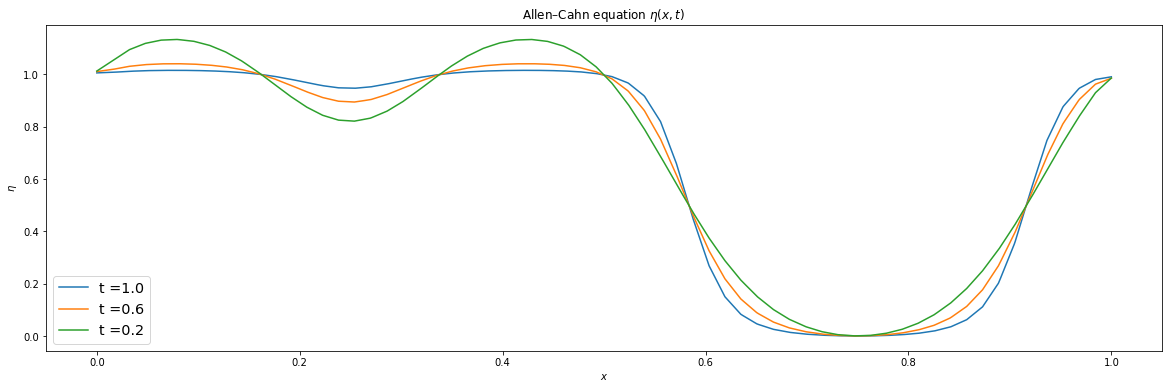

In [68]:
#initial function choosen
def eta_0(x):
    return sin(2*pi*x)+1


figure(figsize=(20,6))
eta, basis = solve_allen_cahan(eta_0, eps=0.01, dt=0.1, ndofs=64, degree=1)
_= plot_solution(eta, basis, stride=4, resolution=1025)

## Step 3

In [ ]:
resolution = 1024
eps = [.01, .001]
ndofs = [16, 32, 64, 128]
degree = [1, 2, 3]
dt = [.25, .125, .0625, .03125, .015625]